In [10]:
# Set up environment and imports
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings

In [18]:
# Define constants
image_size = 128
batch_size = 32
k_folds = 5
epochs = 12
raw_dir = 'PlantVillage-Dataset/raw/color'
base_output = 'split_dataset'
test_ratio = 0.15
data_dir = 'split_dataset/train'

# Building custom CNN model

# -- Custom CNN model: data pre-processing phase --
# Split raw dataset into train/test folders (only "Tomato*" folders)
for split in ['train', 'test']:
    os.makedirs(os.path.join(base_output, split), exist_ok=True)

for class_name in os.listdir(raw_dir):
    if not class_name.startswith('Tomato'):
        continue  # Skip non-Tomato classes
    class_path = os.path.join(raw_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    train_imgs, test_imgs = train_test_split(images, test_size=test_ratio, random_state=42)

    for split, split_imgs in zip(['train', 'test'], [train_imgs, test_imgs]):
        split_class_dir = os.path.join(base_output, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in split_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_class_dir, img)
            shutil.copyfile(src, dst)

# Prepare DataFrame for training images
filepaths, labels = [], []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for fname in os.listdir(class_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepaths.append(os.path.join(class_path, fname))
            labels.append(class_name)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Encode labels
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])
num_classes = len(le.classes_)


In [19]:
# -- Custom CNN model: model building and training phase --
# Set up cross-validation
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=42)
datagen = ImageDataGenerator(rescale=1./255) # rescaling (normalisation)
warnings.filterwarnings('ignore')
for fold, (train_idx, val_idx) in enumerate(sss.split(df['filepath'], df['encoded_label'])):
    print(f"\n--- Fold {fold+1} ---")
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]
    # split into train and validation set
    train_gen = datagen.flow_from_dataframe(
        train_df,
        x_col='filepath',
        y_col='label',
        target_size=(image_size, image_size), # image resizing
        batch_size=batch_size,
        class_mode='categorical', # categorical encoding (one-hot)
        shuffle=True,
        seed=42
    )

    val_gen = datagen.flow_from_dataframe(
        val_df,
        x_col='filepath',
        y_col='label',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # custom CNN model
    model = Sequential([
        Input(shape=(image_size, image_size, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_gen, validation_data=val_gen, epochs=epochs)

# Prepare test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'split_dataset/test',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


--- Fold 1 ---
Found 13117 validated image filenames belonging to 10 classes.
Found 2315 validated image filenames belonging to 10 classes.
Epoch 1/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 72s 174ms/step - accuracy: 0.4546 - loss: 1.6135 - val_accuracy: 0.8207 - val_loss: 0.5709
Epoch 2/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 73s 179ms/step - accuracy: 0.7681 - loss: 0.6905 - val_accuracy: 0.8518 - val_loss: 0.4388
Epoch 3/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 101s 246ms/step - accuracy: 0.8182 - loss: 0.5331 - val_accuracy: 0.8631 - val_loss: 0.4007
Epoch 4/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 93s 227ms/step - accuracy: 0.8501 - loss: 0.4527 - val_accuracy: 0.8553 - val_loss: 0.4227
Epoch 5/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 87s 211ms/step - accuracy: 0.8748 - loss: 0.3704 - val_accuracy: 0.9214 - val_loss: 0.2333
Epoch 6/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 87s 213ms/step - accuracy: 0.8916 - loss: 0.3144 - val_accuracy: 0.9222 - val_loss: 0.2206
Epoch 7/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 85s 208ms/step - accuracy: 0.909

86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step


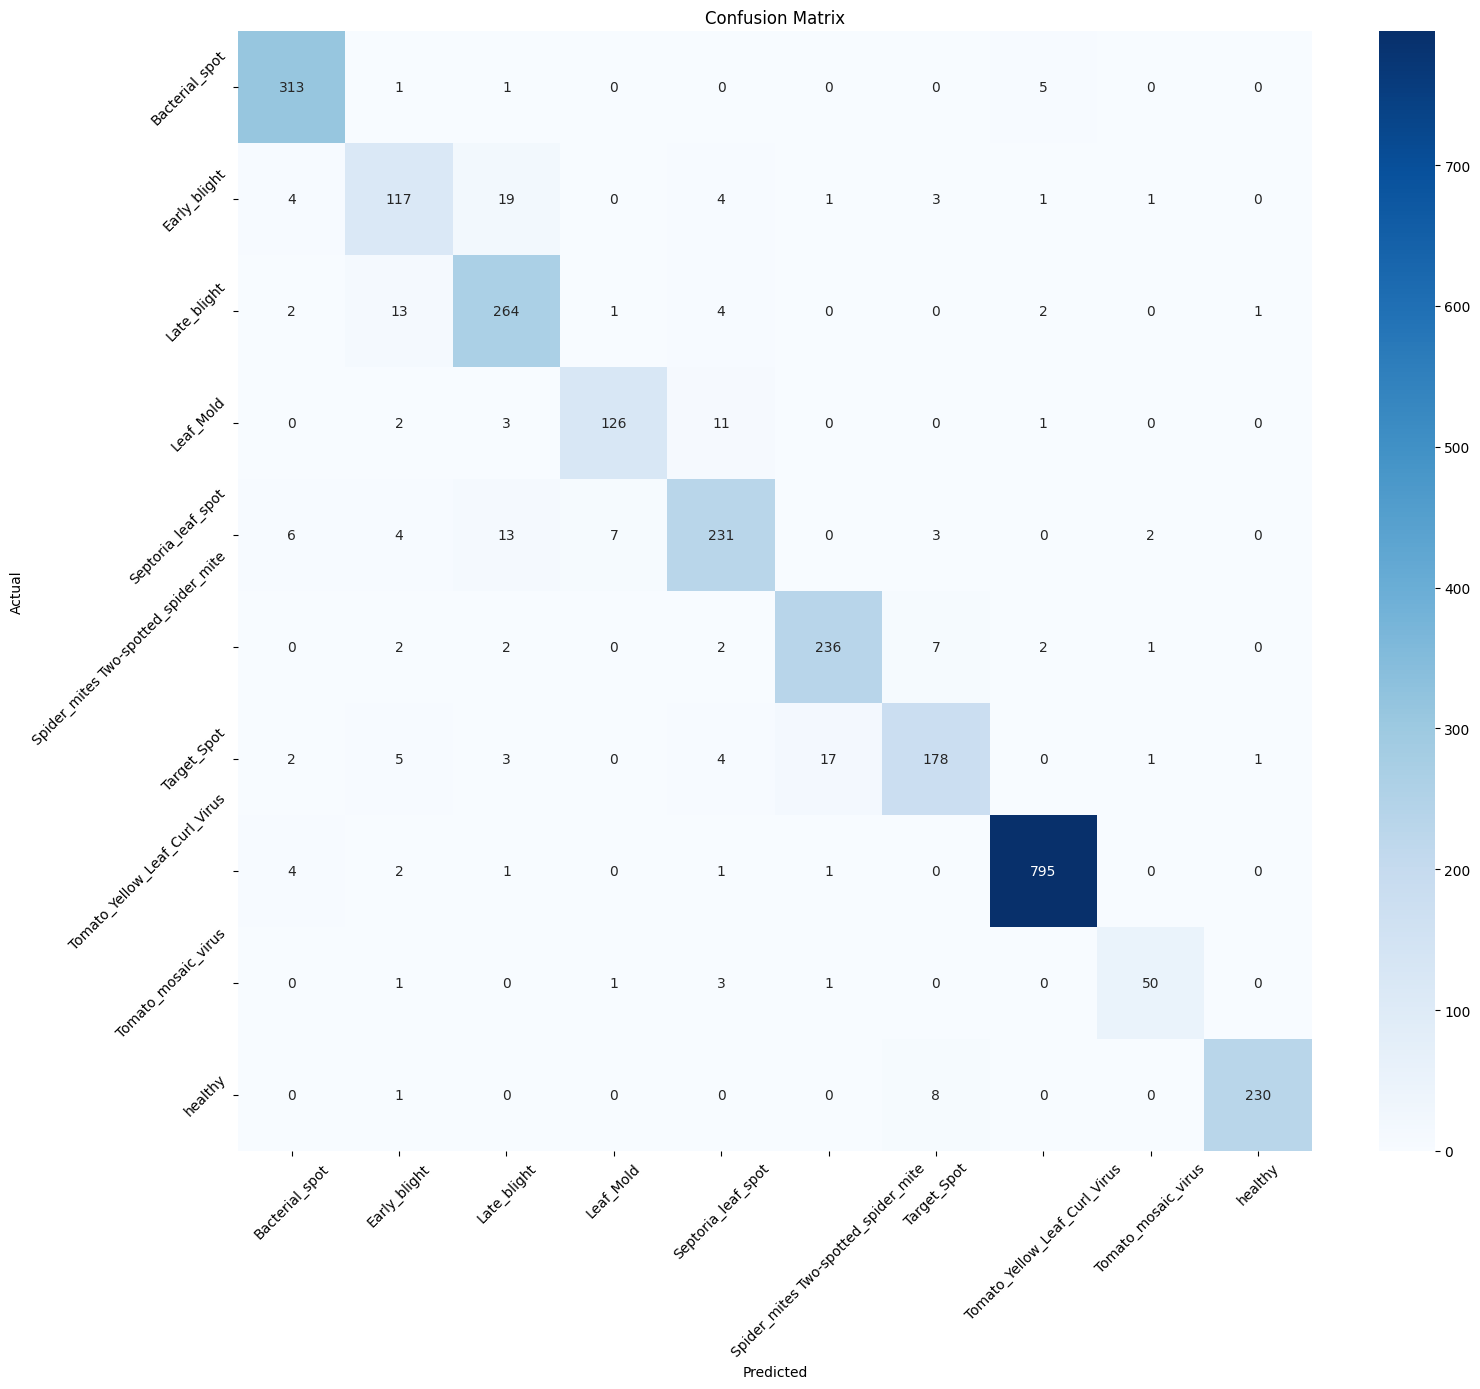

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.95      0.98      0.96       320
                        Early_blight       0.79      0.78      0.79       150
                         Late_blight       0.86      0.92      0.89       287
                           Leaf_Mold       0.93      0.88      0.91       143
                  Septoria_leaf_spot       0.89      0.87      0.88       266
Spider_mites Two-spotted_spider_mite       0.92      0.94      0.93       252
                         Target_Spot       0.89      0.84      0.87       211
       Tomato_Yellow_Leaf_Curl_Virus       0.99      0.99      0.99       804
                 Tomato_mosaic_virus       0.91      0.89      0.90        56
                             healthy       0.99      0.96      0.98       239

                            accuracy                           0.93      2728
                           macro avg       0.91      0.91     

In [20]:
# -- Custom CNN model: testing and evaluation phase --
# Predict labels on test data
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.classes

# Get class labels (in correct order)
class_labels = [label.replace("Tomato___", "") for label in test_generator.class_indices.keys()]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Convert to DataFrame for nicer formatting
report_df = pd.DataFrame(report).transpose()

print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
# Deploying SVM and RF based on refined data from pre-trained CNN model - ResNet50
# set up environment and imports
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# define constants
raw_dir = 'PlantVillage-Dataset/raw/color'
classes = sorted(os.listdir(raw_dir))
# Keep only tomato classes
classes = [c for c in classes if c.startswith('Tomato')]
image_size = 224
batch_size = 32
n_splits = 5
filepaths = []
labels = []

for label in classes:
    if not label.startswith('Tomato'):
        continue
    class_dir = os.path.join(raw_dir, label)
    for fname in os.listdir(class_dir):
        filepaths.append(os.path.join(class_dir, fname))
        labels.append(label)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
# Create factorized labels with index mapping
df['encoded_label'], uniques = pd.factorize(df['label'])
# Match clean class names to encoding order
clean_class_names = [label.replace('Tomato___', '') for label in uniques]

# Load ResNet50 without top layer
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(image_size, image_size, 3))

def extract_features(img_paths):
    features = []
    for path in tqdm(img_paths, desc="Extracting features"):
        img = load_img(path, target_size=(image_size, image_size))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        features.append(img_array)
    features = np.array(features)
    return resnet_model.predict(features, batch_size=batch_size)

# Precompute features
X = extract_features(df['filepath'].values)
y = df['encoded_label'].values
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
# -- SVM model --
svm_scores = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"\n--- Fold {fold + 1} ---")
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    svm = SVC(kernel='rbf', probability=True)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_val)
    acc_svm = accuracy_score(y_val, y_pred_svm)
    svm_scores.append(acc_svm)
    print(f"SVM Accuracy: {acc_svm:.4f}")

# Final evaluation on test set
final_svm = SVC(kernel='rbf', probability=True)
final_svm.fit(X_train_full, y_train_full)
y_test_pred_svm = final_svm.predict(X_test)
print("SVM Test Report:")
print(classification_report(y_test, y_test_pred_svm, target_names=clean_class_names))
# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clean_class_names, yticklabels=clean_class_names)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# -- RF model --
rf_scores = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"\n--- Fold {fold + 1} ---")
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_val)
    acc_rf = accuracy_score(y_val, y_pred_rf)
    rf_scores.append(acc_rf)
    print(f"RF Accuracy: {acc_rf:.4f}")

# Final evaluation on test set
final_rf = RandomForestClassifier(n_estimators=100, random_state=42)
final_rf.fit(X_train_full, y_train_full)
y_test_pred_rf = final_rf.predict(X_test)
print("RF Test Report:")
print(classification_report(y_test, y_test_pred_rf, target_names=clean_class_names))
# Confusion Matrix for RF
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=clean_class_names, yticklabels=clean_class_names)
plt.title("RF Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()